## Analysis of trained SAEs

In [1]:
#load packages

import math, time
import torch
import os
import sys
sys.path.append('../..')
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
#SET THE PATH OF DATA and name of dataset
DATA_PATH = './data/' #change this to your data path
dataname = '2dgaussian_diffmag'


In [ ]:

from functions.get_data import data_n_loaders
# LAB_DIR = os.environ['USERDIR'] #change as needed
# DATA_PATH = LAB_DIR+'/data'

#load entire train data and transform parameters
batch_size = 512 #doesnt matter since we disregard the dataloader
_, _,train_data, _, mean, scale = data_n_loaders(dataname, batch_size, return_data=True, \
      data_path=DATA_PATH, standardise_data = True, return_transform=True)
mean = mean.squeeze()
train_data_raw = (train_data.data/scale) + mean


#sample equal number of points from each concept
torch.manual_seed(0)
numpoints_perconcept = 1000
num_concepts = 6
data_subset_perconcept = []
labels_subset_perconcept = []
for i in range(num_concepts):
    indices = train_data.labels == i
    rand_indices_i = torch.randperm(indices.sum())[:numpoints_perconcept]
    data_subset_perconcept.append(train_data_raw[indices][rand_indices_i])
    labels_subset_perconcept.append(train_data.labels[indices][rand_indices_i])
data_subset_raw = torch.cat(data_subset_perconcept, dim=0)
data_subset = (data_subset_raw - mean) * scale #transform same as training data (to input to model)
labels_subset = torch.cat(labels_subset_perconcept, dim=0)

In [ ]:
#choose models to visualize

#get exptnames from folder names within saved_models
exptnames = []
for root, dirs, files in os.walk('saved_models'):
    for dir in dirs:
        if 'checkpoints_' in dir:
            if ('gamreg' not in dir and 'topk' not in dir) or 'k15' in dir:
                continue
            if 'w128' not in dir:
                continue
            exptnames.append(dir.split('checkpoints_')[1])

#sort exptnames to have all with same sae_type (name after the first _ within exptnames) together; after saename, the float following must be used for sorting
order = {'relu': 0, 'jumprelu': 1, 'topk': 2, 'spade': 3}
exptnames = sorted(exptnames, key=lambda x: (order[x.split('_')[1]]))

#get parameters from experiment names
saetypes = []
for exptname in exptnames:
    if 'spade' in exptname:
        saetypes.append('sparsemax_dist')
    elif 'topk_relu' in exptname:
        saetypes.append('topk_relu')
    else:
        saetypes.append(exptname.split('_')[1])
kvals_all = []
for exptname in exptnames:
    if 'topk' in exptname:
        kvals_all.append(int(exptname.split('_k')[1].split('_')[0]))
    else:
        kvals_all.append(0)
gammavals_all = []
for exptname in exptnames:
    if 'gamreg' in exptname:
        gammavals_all.append(float(exptname.split('_gamreg')[1].split('_')[0]))
    else:
        gammavals_all.append(0)
max_iters = []
for exptname in exptnames:
    epochs = []
    for root, dirs, files in os.walk('saved_models/checkpoints_'+exptname):
        for file in files:
            if 'model_' in file:
                epochs.append(int(file.split('_')[1].split('.pt')[0].split('epochs')[0]))
    max_iters.append(max(epochs))

# choose which models (hyperparams) to plot
kvals_plot = [2*i for i in range(1, 11)]
gammavals_relu_plot = [1.0, 0.5, 0.005, 0.001, 0.0005, 0.0001, 5e-05, 1e-05, 5e-06, 1e-06]
gammavals_jumprelu_plot = [0.1, 0.05, 0.005, 0.00125, 0.001, 0.0005, 0.0001, 5e-05, 1e-05, 5e-06]
gammavals_spade_plot = [0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001, 5e-05, 1e-05]
relu_indices2 = [i for i in range(len(exptnames)) if saetypes[i] == 'relu' and gammavals_all[i] in gammavals_relu_plot]
jumprelu_indices2 = [i for i in range(len(exptnames)) if saetypes[i] == 'jumprelu' and gammavals_all[i] in gammavals_jumprelu_plot]
topk_indices2 = [i for i in range(len(exptnames)) if saetypes[i] == 'topk_relu' and kvals_all[i] in kvals_plot]
spade_indices2 = [i for i in range(len(exptnames)) if saetypes[i] == 'sparsemax_dist' and gammavals_all[i] in gammavals_spade_plot]
numpoints_persae = len(relu_indices2)
allindices2 = relu_indices2 + jumprelu_indices2 + topk_indices2 + spade_indices2
exptnames = [exptnames[i] for i in allindices2]
saetypes = [saetypes[i] for i in allindices2]
kvals_all = [kvals_all[i] for i in allindices2]
gammavals_all = [gammavals_all[i] for i in allindices2]
max_iters = [max_iters[i] for i in allindices2]
assert len(set(max_iters))==1 #max-iters same for all models

In [ ]:
#load trained models for chosen hyperparams
from models import SAE
width = 128 #of sae
modelsall = []
dimdata = 2
for i in range(len(exptnames)):
    exptnamei = exptnames[i]
    normalize_decoder = False if saetypes[i] == 'sparsemax_dist' else True
    modeli = SAE(dimdata, width, sae_type=saetypes[i],kval_topk=kvals_all[i], normalize_decoder=normalize_decoder)
    state_dict = torch.load(f"./saved_models/checkpoints_{exptnamei}/model_{max_iters[i]}epochs.pt")
    modeli.load_state_dict(state_dict['model'])
    modelsall.append(modeli)

In [5]:
#get latent representations (sparse codes) on data subset
latent_reps_all = [] #latent reps on data subset for each model
mse_all = []
meannorm2_all = []
datavar_all = []
device = 'cuda'
for i in range(len(exptnames)):
    modeli = modelsall[i].to(device)
    with torch.no_grad():
        pts_recon, latent_reps = modeli(data_subset.to(device), return_hidden=True)
        mse = ((pts_recon - data_subset.to(device))**2).sum(dim=-1).mean().item()
        mean_norm2 = (data_subset**2).sum(dim=-1).mean().item()
        mse_all.append(mse)
        meannorm2_all.append(mean_norm2)
        datavar = data_subset.var(dim=0).sum().item()
        datavar_all.append(datavar)
        latent_reps_all.append(latent_reps.detach().cpu())

In [ ]:
saes_order = ['relu', 'jumprelu', 'topk_relu', 'sparsemax_dist']

#get f1 score of each latent for each class
eps = 1e-12
f1_all = torch.zeros((len(exptnames), num_concepts, width))
precision_all = torch.zeros((len(exptnames), num_concepts, width))
recall_all = torch.zeros((len(exptnames), num_concepts, width))
l0_all = torch.zeros((len(exptnames)))
for i in range(len(exptnames)):
    latents_i = latent_reps_all[i]
    # threshold = torch.quantile(latents_i[latents_i>0.0].flatten(), 0.1) #10th percentile of data
    threshold = 1e-6
    l0_all[i] = (latents_i>threshold).sum(dim=-1).float().mean()
    for c in range(num_concepts):
        truepos = (latents_i[labels_subset==c,:]>threshold).sum(0).float()
        falsepos = (latents_i[labels_subset!=c,:]>threshold).sum(0).float()
        allpos = (labels_subset==c).sum().float()
        pospred = (latents_i>threshold).sum(0).float()
        precision = truepos/(pospred+eps)
        recall = truepos/(allpos+eps)
        f1 = 2*precision*recall/(precision+recall+eps)
        f1_all[i,c, :] = f1
        precision_all[i,c, :] = precision
        recall_all[i,c, :] = recall
monosemantic_latents = torch.argmax(f1_all, dim=-1)
ordered_latents = torch.argsort(f1_all, dim=-1, descending=True)
f1_sorted = torch.gather(f1_all, dim=-1, index=ordered_latents)
precision_sorted = torch.gather(precision_all, dim=-1, index=ordered_latents)
recall_sorted = torch.gather(recall_all, dim=-1, index=ordered_latents)

#group gamma, k values by sae_type
gammavals_saegrouped = []
kvals_saegrouped = []
for i in range(len(saes_order)):
    gammavals_saegrouped.append(sorted([gammavals_all[j] for j in range(len(exptnames)) if saetypes[j] == saes_order[i]]))
    kvals_saegrouped.append(sorted([kvals_all[j] for j in range(len(exptnames)) if saetypes[j] == saes_order[i]]))

#rearrange f1 scores and L0 (sparsity) for plotting
l0_lineplot = torch.zeros((len(saes_order), numpoints_persae))
f1mean_lineplot = torch.zeros((num_concepts, len(saes_order), numpoints_persae))
f1std_lineplot = torch.zeros((num_concepts, len(saes_order), numpoints_persae))
shownum = 5
for i in range(num_concepts):
    for j in range(len(exptnames)):
        colid = saes_order.index(saetypes[j])  
        if saetypes[j] == 'topk_relu':
            l0id = kvals_saegrouped[colid].index(kvals_all[j])
        else:
            l0id = gammavals_saegrouped[colid].index(gammavals_all[j])
        l0_lineplot[colid, l0id] =  l0_all[j]
        f1mean_lineplot[i, colid, l0id] = f1_sorted[j, i, :shownum].mean()
        f1std_lineplot[i, colid, l0id] = f1_sorted[j, i, :shownum].std()


In [ ]:
#get latent receptive fields
xlims = [-2, 2]
ylims = [-2, 2]
numpoints_axis = 1000
x, y = torch.meshgrid(torch.linspace(xlims[0], xlims[1], numpoints_axis), torch.linspace(ylims[0], ylims[1], numpoints_axis))
Xmesh_raw = torch.stack([x, y], dim=2).view(-1, 2)
Xmesh = scale*(Xmesh_raw - mean.reshape((1, 2))) #transform to pass to the model
rfall = []
heatall = []
for i in range(len(exptnames)):
    with torch.no_grad():
        modeli = modelsall[i]
        _, latents = modeli(Xmesh.to(device), return_hidden=True)
        latents_s = latents.reshape((numpoints_axis, numpoints_axis, width)).T
        latents_s = latents_s.detach().cpu()
        rfall.append((latents_s>1e-6).float())
        heatall.append(latents_s)

In [ ]:
# choose models to plot receptive fields for
plot_concepts = [2,5] 
concept_colors = ['orange', 'purple']
exptnames_plot = []
plot_indices = []
for i in range(len(saes_order)):
    temp = f1mean_lineplot[plot_concepts, :,:].mean(dim=0)[i,:]
    index_l0_highestmeanf1 = temp.argmax().item()
    if saes_order[i] == 'topk_relu':
        l0_plot_index = kvals_saegrouped[i][index_l0_highestmeanf1]
        index_l0_saei = [j for j in range(len(exptnames)) if saetypes[j] == saes_order[i] and kvals_all[j] == l0_plot_index]
    else:
        l0_plot_index = gammavals_saegrouped[i][index_l0_highestmeanf1]
        index_l0_saei = [j for j in range(len(exptnames)) if saetypes[j] == saes_order[i] and gammavals_all[j] == l0_plot_index]
    assert len(index_l0_saei) == 1
    plot_indices.append(index_l0_saei[0])
    exptnames_plot.append(exptnames[index_l0_saei[0]])

In [ ]:
#data-data correlations, latent-latent correlations, spectral clusters
Cdatacos = []
Clatentcos = []
concept_of_latents = torch.zeros((len(exptnames), width))
for j in range(len(exptnames)):
    for i in range(width):
        concept_of_latents[j,i] = torch.argmax(f1_all[j, :, i])
latents_order = torch.argsort(concept_of_latents, dim=-1)
for i in range(len(exptnames)):    
    latents = latent_reps_all[i][:,latents_order[i]]
    deadlatents = (latents>1e-12).sum(dim=0)==0.0
    latents = torch.cat([latents[:,~deadlatents], latents[:,deadlatents]], dim=1)
    
    #sparse code correlations for data pairs
    Corr = latents @ latents.T
    norm = torch.norm(latents, dim=1).unsqueeze(1)
    Cdatacos.append( Corr/ (norm @ norm.T + 1e-12) )
    
    #sparse code correlations for latent pairs
    Corr = latents.T @ latents
    norm = torch.norm(latents, dim=0).unsqueeze(1)
    Corr = Corr/ (norm @ norm.T + 1e-12)
    Clatentcos.append(Corr)

#compute stable rank of the correlation matrix
stableranks = []
for i in range(len(exptnames)):
    if i in plot_indices:
        sr = torch.trace(Cdatacos[i])/torch.linalg.matrix_norm(Cdatacos[i], ord=2)
        stableranks.append(sr.item())
    else:
        stableranks.append(-1) #not computed since not plotted here


#spectral clustering on data-data correlation matrix
from sklearn.cluster import spectral_clustering as sc
dataorder_all = []
clusters_all = []
clustersizes_all = []
tic = time.perf_counter()
for i in range(len(exptnames)):
    if i in plot_indices:
        n_clusters = math.ceil(stableranks[i])
        labels = sc(Cdatacos[i].cpu().numpy(), n_clusters=n_clusters, random_state=0)
        labels = torch.tensor(labels)
        order = torch.argsort(labels)
        # labels, order = spectral_clustering(Cdatacos[i], n_clusters=math.ceil(stableranks[i]), normalized=False, return_clusteredorder=True)
        dataorder_all.append(order)
        clusters_all.append(labels)
        clustersizes = []
        for j in range(n_clusters):
            clustersizes.append((labels==j).sum())
        clustersizes_all.append(clustersizes)
        print(f"{exptnames[i]} done")
    else: #not plotted so spectral clustering not computed
        dataorder_all.append([])
        clusters_all.append([])
        clustersizes_all.append([])
toc = time.perf_counter()
print(f"Time for spectral clustering {len(exptnames)} data-data corrs = {(toc-tic):.2f}s")


still801_relu_gamreg0.0001_w128_021725 done
logic576_jumprelu_gamreg5e-05_w128_021725 done
guava893_topk_relu_k18_w128_021725 done
light893_spade_gamreg0.001_w128_021725 done
Time for spectral clustering 40 data-data corrs = 18.93s


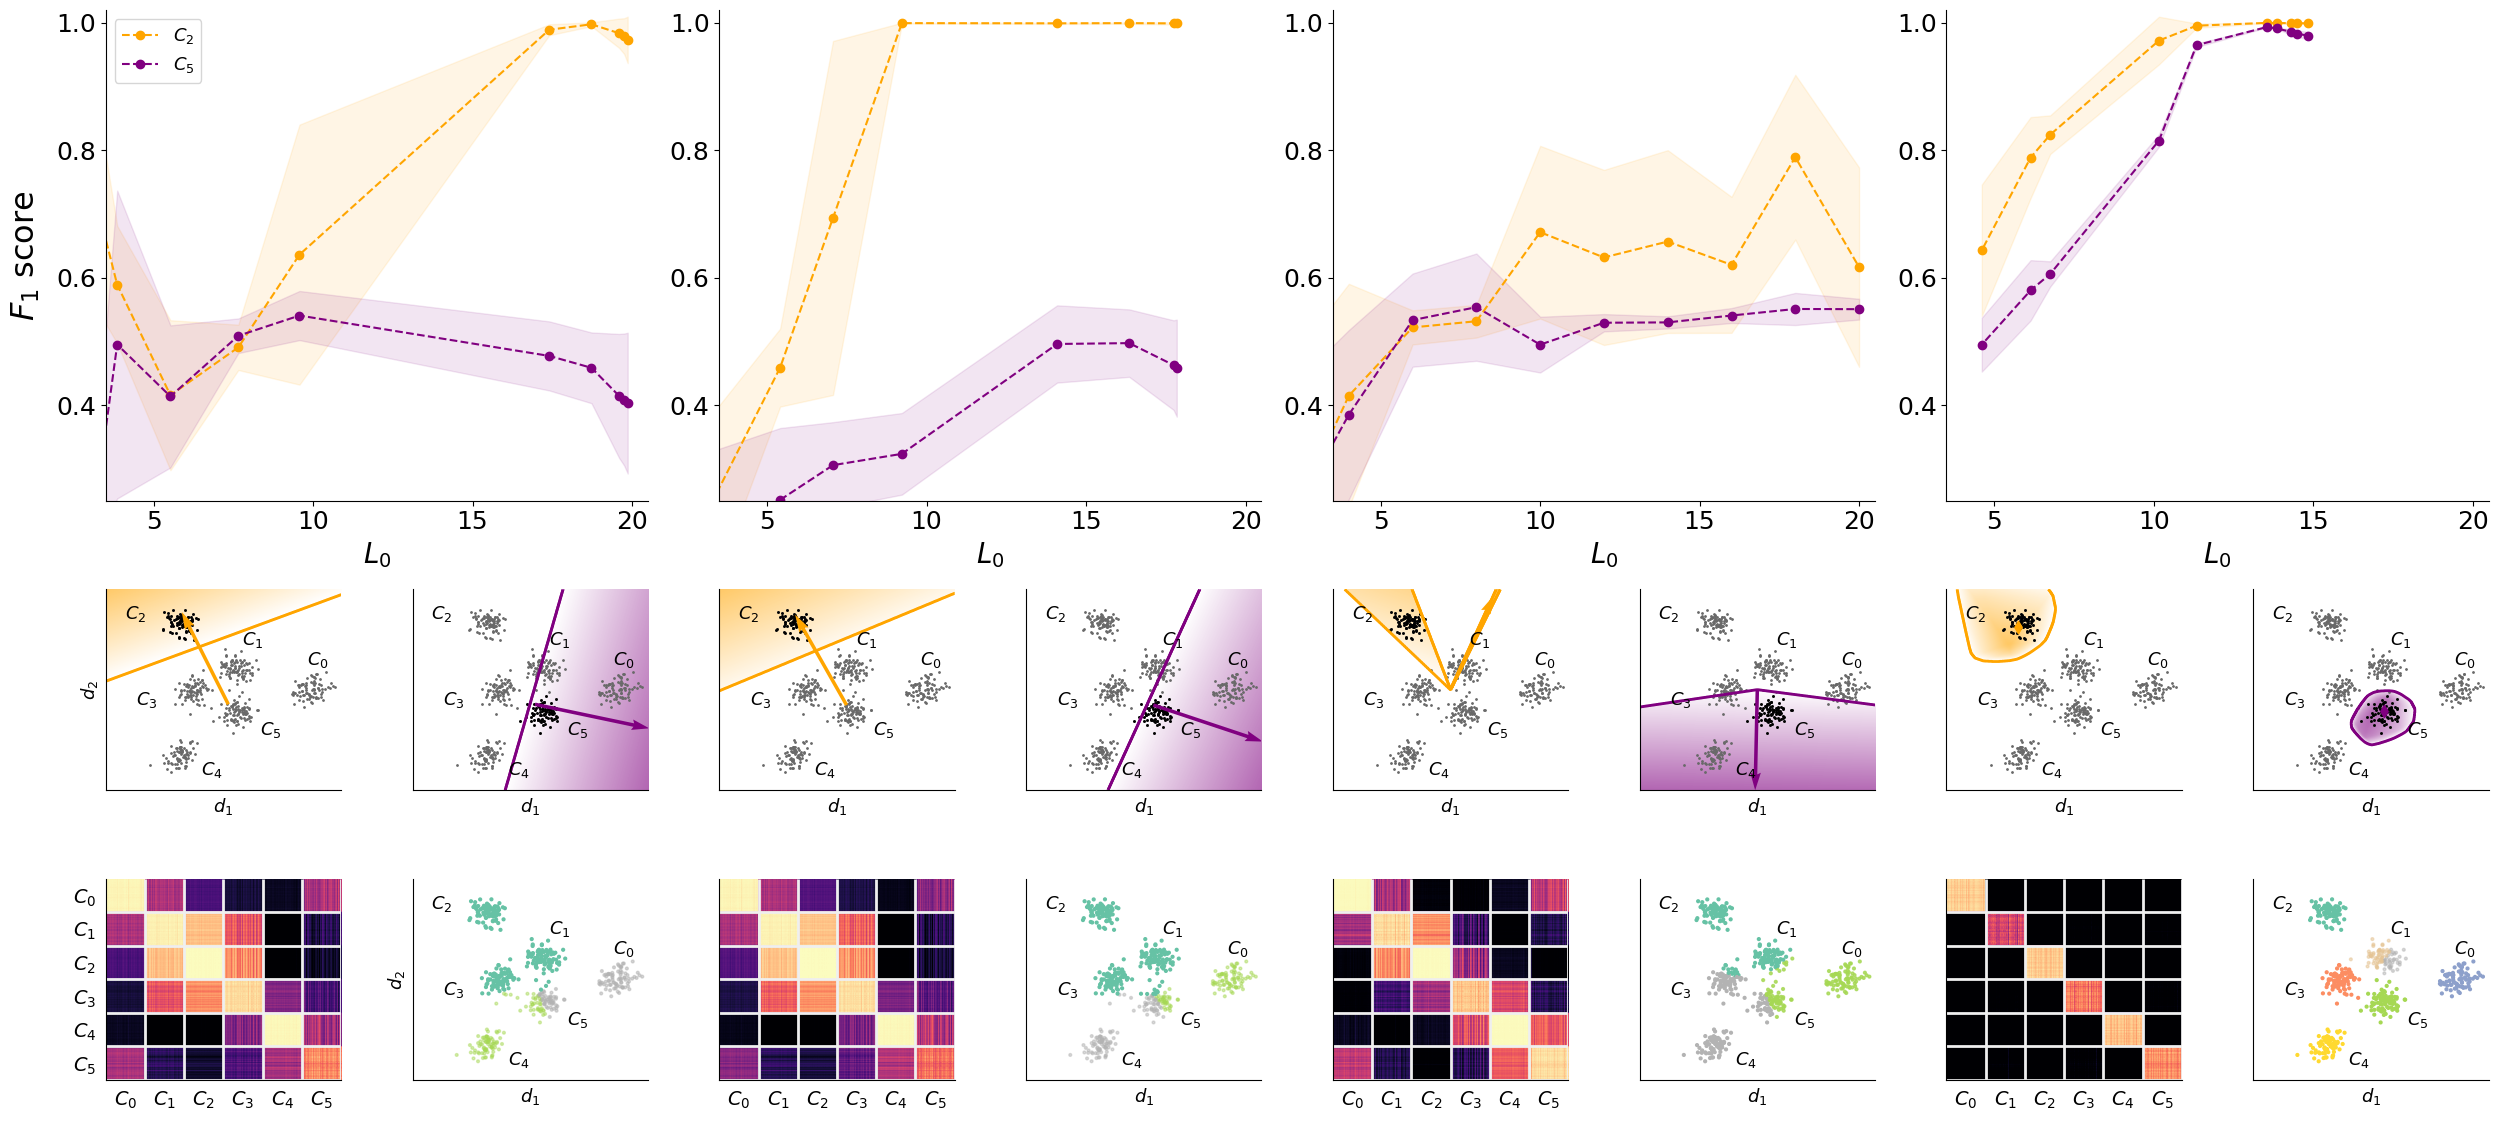

In [ ]:
#show only final receptive fields for all models, data in separate figures, each having 4X5 subplots (one per neuron)
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams.update({'font.size': 13})
row_heights = [1, 0.5, 0.5, 0.5, 0.5]
numcols = len(exptnames_plot) 
numrows = 3
# fig, axs = plt.subplots(numrows, numcols, figsize=(2.5*numcols, 2.5*(3)), sharey='row', constrained_layout=True, gridspec_kw={'height_ratios': row_heights})
scaleval = 3

#define figure layout and subplots
plt.figure(figsize=(scaleval*8.4,scaleval*(3.8)))
ax1 = plt.subplot2grid((4, 8), (0, 0), rowspan=2, colspan=2)
ax2 = plt.subplot2grid((4, 8), (0, 2), rowspan=2, colspan=2)
ax3 = plt.subplot2grid((4, 8), (0, 4), rowspan=2, colspan=2)
ax4 = plt.subplot2grid((4, 8), (0, 6), rowspan=2, colspan=2)
ax5 = plt.subplot2grid((4, 8), (2, 0), rowspan=1, colspan=1)
ax6 = plt.subplot2grid((4, 8), (2, 1), rowspan=1, colspan=1)
ax7 = plt.subplot2grid((4, 8), (2, 2), rowspan=1, colspan=1)
ax8 = plt.subplot2grid((4, 8), (2,3), rowspan=1, colspan=1)
ax9 = plt.subplot2grid((4, 8), (2, 4), rowspan=1, colspan=1)
ax10 = plt.subplot2grid((4, 8), (2, 5), rowspan=1, colspan=1)
ax11 = plt.subplot2grid((4, 8), (2, 6), rowspan=1, colspan=1)
ax12 = plt.subplot2grid((4, 8), (2, 7), rowspan=1, colspan=1)
ax13 = plt.subplot2grid((4, 8), (3, 0), rowspan=1, colspan=1)
ax14 = plt.subplot2grid((4, 8), (3, 1), rowspan=1, colspan=1)
ax15 = plt.subplot2grid((4, 8), (3, 2), rowspan=1, colspan=1)
ax16 = plt.subplot2grid((4, 8), (3, 3), rowspan=1, colspan=1)
ax17 = plt.subplot2grid((4, 8), (3, 4), rowspan=1, colspan=1)
ax18 = plt.subplot2grid((4, 8), (3, 5), rowspan=1, colspan=1)
ax19 = plt.subplot2grid((4, 8), (3, 6), rowspan=1, colspan=1)
ax20 = plt.subplot2grid((4, 8), (3, 7), rowspan=1, colspan=1)
axs = np.array([ [ax1, ax2, ax3, ax4], [ax5, ax7, ax9, ax11], [ax6, ax8, ax10, ax12], [ax13, ax15, ax17, ax19], [ax14, ax16, ax18, ax20] ])

torch.manual_seed(0)
concept_names = ['Concept '+str(plot_concepts[i]) for i in range(len(plot_concepts))]

from matplotlib.colors import LinearSegmentedColormap
# Define a custom colormap that interpolates from white to your desired color
colormaps = []
for k in range(len(plot_concepts)):
    custom_cmap = LinearSegmentedColormap.from_list("custom", ["white", concept_colors[k]])
    colormaps.append(custom_cmap)
indices = torch.randperm(len(data_subset))[:500]
labels_forindices = labels_subset[indices]

#make plots
for j in range(len(exptnames_plot)):
    for k in range(len(plot_concepts)):

        #show datapoints
        axs[k+1,j].scatter(data_subset_raw[indices,0], data_subset_raw[indices,1], \
            s=1, c='dimgray')
        axs[k+1,j].scatter(data_subset_raw[indices,0][labels_forindices==plot_concepts[k]], data_subset_raw[indices,1][labels_forindices==plot_concepts[k]], \
            s=1, c='k') #active concept- whose receptive fields are shown
            
        #visualize receptive fields
        heatjk = heatall[plot_indices[j]][monosemantic_latents[plot_indices[j],plot_concepts[k]].item(),:,:]
        axs[k+1,j].imshow(heatjk, alpha=0.6,
            extent=[xlims[0], xlims[1], ylims[0], ylims[1]], origin='lower', cmap=colormaps[k])
        
        #set axis labels, ticks, limits
        axs[k+1,j].set_xlabel(r"$d_1$", fontsize=13)
        if j==0 and k==0:
            axs[k+1,j].set_ylabel(r"$d_2$", fontsize=13)
        axs[k+1,j].set_xticks([])
        axs[k+1,j].set_yticks([])
        axs[k+1,j].set_xlim(*xlims)
        axs[k+1,j].set_ylim(*ylims)
        #draw boundaries around receptive fields
        axs[k+1,j].contour(heatjk, levels=[torch.quantile(heatjk.flatten(), 0.1).item()], colors=concept_colors[k], \
            linewidths=2, extent=[xlims[0], xlims[1], ylims[0], ylims[1]])
        # if j==len(exptnames)-1: #sparsemax
        
        #show encoder weights
        protos = modelsall[plot_indices[j]].Ae.detach().cpu()
        latentid = monosemantic_latents[plot_indices[j],plot_concepts[k]].item()
        
        #points at each encoder weight for SpaDE
        if saetypes[plot_indices[j]] == 'sparsemax_dist':
            protos = protos/scale + mean
            axs[k+1,j].scatter(protos[latentid,0], protos[latentid,1], marker='d', color=concept_colors[k], s=40)
        
        #quivers for encoder weights (directions) for ReLU, TopK, JumpReLU
        else:
            protos = protos*scale
            protos = protos/(1e-12+ protos.norm(dim=1, keepdim=True))
            bdec = modelsall[plot_indices[j]].bd.detach().cpu().squeeze()
            bdec = bdec/scale + mean
            axs[k+1,j].quiver(bdec[0], bdec[1], protos[latentid,0], protos[latentid,1], scale=0.5, scale_units='xy', angles='xy', \
                color=concept_colors[k], width=0.015)

for k in range(len(plot_concepts)):
    for i in range(len(saes_order)):

        #show F1-scores
        axs[0, i].fill_between(l0_lineplot[i, :], 
                   f1mean_lineplot[plot_concepts[k], i, :] - f1std_lineplot[plot_concepts[k], i, :], 
                   f1mean_lineplot[plot_concepts[k], i, :] + f1std_lineplot[plot_concepts[k], i, :], 
                   color=concept_colors[k], alpha=0.1)
        axs[0, i].plot(l0_lineplot[i, :], f1mean_lineplot[plot_concepts[k], i, :], 'o--', c=concept_colors[k], label=f'$C_{plot_concepts[k]}$')
        axs[0, i].set_xlim(3.5, 20.5)
        axs[0, i].set_ylim(0.25, 1.02)
        # axs[0,i].set_xlabel(r"$L_0$")
        # axs[0,i].set_ylabel(r"$F_1$ score")
        axs[0,i].set_xticks([5, 10, 15, 20], labels=[5, 10, 15, 20], fontsize=18)
        axs[0,i].set_xlabel(r"$L_0$", fontsize=20)
        # axs[0,i].tick_params(axis='y', labelsize=10)
        axs[0,i].set_yticks([0.4, 0.6, 0.8, 1.0], labels=[0.4, 0.6, 0.8, 1.0], fontsize=18)
        if i>0:
            axs[0,i].sharey(axs[0,0])
            # axs[0,i].set_yticks([])
        else:
            axs[0,i].set_ylabel(r"$F_1$ score", fontsize=23, labelpad=10)
        axs[0, 0].legend()

# brightness of spectral clusters depends on the cluster size
alphavals_specclus = []
for i in range(len(saes_order)):
    alphas_sci = []
    for j in range(data_subset.size(0)):
        sclabel_j = clusters_all[plot_indices[i]][j]
        clussize_j = clustersizes_all[plot_indices[i]][sclabel_j]
        max_clustersize = max(clustersizes_all[plot_indices[i]])
        alphas_sci.append(clussize_j/max_clustersize)
    alphavals_specclus.append(alphas_sci)

for i in range(len(saes_order)):

    #show sparse code correlations for data pairs
    height, width = Cdatacos[plot_indices[i]].shape[:2]
    axs[3, i].imshow(Cdatacos[plot_indices[i]], cmap='magma', vmin=0, vmax=1,
                    extent=[0, width, height, 0])
    axs[3, i].hlines([numpoints_perconcept*j for j in range(1, num_concepts+1)],
                    0, width, color='#EFEFEF', linewidth=2)
    axs[3, i].vlines([numpoints_perconcept*j for j in range(1, num_concepts+1)],
                    0, height, color='#EFEFEF', linewidth=2)
    axs[3,i].set_xticks(ticks=[500+1000*i for i in range(0, 6)], labels=[r"$C_0$", r"$C_1$", r"$C_2$", r"$C_3$", r"$C_4$", r"$C_5$"], fontsize=14)
    if i==0:
        axs[3,i].set_yticks(ticks=[500+1000*i for i in range(0, 6)], labels=[r"$C_0$", r"$C_1$", r"$C_2$", r"$C_3$", r"$C_4$", r"$C_5$"], fontsize=14)
    else:
        axs[3,i].set_yticks([])
    axs[3,i].tick_params(axis='x', bottom=False)  # Remove x-axis ticks
    axs[3,i].tick_params(axis='y', left=False)  # Remove y-axis tick

    #show spectral clusters on above data-data correlation matrix
    axs[4, i].scatter(data_subset_raw[indices,0], \
        data_subset_raw[indices,1], \
            c=clusters_all[plot_indices[i]][indices], \
                cmap='Set2', alpha=torch.tensor(alphavals_specclus[i])[indices], s=4)
    axs[4,i].set_xticks([])
    axs[4,i].set_yticks([])
    if i==0:
        axs[4,i].set_ylabel(r"$d_2$", fontsize=13)
    axs[4,i].set_xlabel(r"$d_1$", fontsize=13)
    axs[4,i].set_xlim(*xlims)
    axs[4,i].set_ylim(*ylims)
    
    #names of concepts
    color_clus = 'k'
    for k in [1, 2, 4]:
        axs[k,i].text(1.6, 0.6, r"$C_0$", fontsize=13, color=color_clus, ha='center', va='center')
        axs[k,i].text(0.5, 1.0, r"$C_1$", fontsize=13, color=color_clus, ha='center', va='center')
        axs[k,i].text(-1.5, 1.5, r"$C_2$", fontsize=13, color=color_clus, ha='center', va='center')
        axs[k,i].text(-1.3, -0.2, r"$C_3$", fontsize=13, color=color_clus, ha='center', va='center')
        axs[k,i].text(-0.2, -1.6, r"$C_4$", fontsize=13, color=color_clus, ha='center', va='center')
        axs[k,i].text(0.8, -0.8, r"$C_5$", fontsize=13, color=color_clus, ha='center', va='center')
    
    #turn off top and right spines
    for k in [0, 1, 2, 3, 4]:
        axs[k,i].spines['top'].set_visible(False)
        axs[k,i].spines['right'].set_visible(False)
    
for ax in axs.flatten():
    ax.set_aspect('auto')

# for i in range(axs.shape[0]):
#     for j in range(axs.shape[1]):
#         if i>0:
#             axs[i,j].set_aspect('equal')
#         else:
#             axs[i,j].set_aspect('auto')
    
plt.tight_layout()
# plt.subplots_adjust(wspace=0.5)
# plt.show()
# plt.savefig('./figs/sep_mainfigX.pdf', bbox_inches='tight', dpi=300)